# SAMPLING THE POSTERIOR USING MCMC

In [4]:
#!pip install tqdm
#!pip install galpy
#!pip install astropy
#!pip install emcee
#!pip install corner

In [5]:
import numpy as np 
import matplotlib.pyplot as plt

import scipy as sp
import astropy
from astropy import constants, units

import corner

import galpy

import emcee

import pandas as pd

import tqdm

import dynesty

import pickle

### Define global constants

In [6]:
r_sun = 8.34*units.kpc
v_sun = 220*units.km/units.s
G = constants.G

In [7]:
huang_data = pd.read_csv('./Huang data.csv',
                   delimiter=',',skiprows=1,names=["r","v","v_err","type"])

## Defining the stellar bulge matter distribution and circular velocity

According to Sofue (https://ned.ipac.caltech.edu/level5/Sept16/Sofue/Sofue4.html), since it was shown that the de Vaucouleurs law fails to fit the observed central rotation, another model has been proposed, called the exponential sphere model. In this model, the volume mass density ρ is represented by an exponential function of radius r with a scale radius a as 

$$
\rho(r) = \rho_c e^{-r/a} \tag{51}
$$

The mass involved within radius $r$ is given by
$$
M(R) = M_0 F(x), \tag{52}
$$
where $x = r/a$ and
$$
F(x) = 1 - e^{-x}(1 + x + x^2/2). \tag{53}
$$

The total mass is given by
$$
M_0 = \int_0^\infty 4\pi r^2 \rho dr = 8 \pi a^3 \rho_c. \tag{54}
$$

The circular rotation velocity is then calculated by
$$
V(r) = \sqrt{\frac{GM}{r}} = \sqrt{\frac{GM_0}{a} F\left(\frac{r}{a}\right)}. \tag{55}
$$

In this model, the rotational velocity has a narrower peak near the characteristic radius in a logarithmic plot as shown in figure 26. Note that the exponential-sphere model is nearly identical to that for the Plummer’s law, and the rotation curves have almost identical profiles. 

According to Sofue: "In this context, the Plummer law can be used to fit the central bulge components in place of the present models""


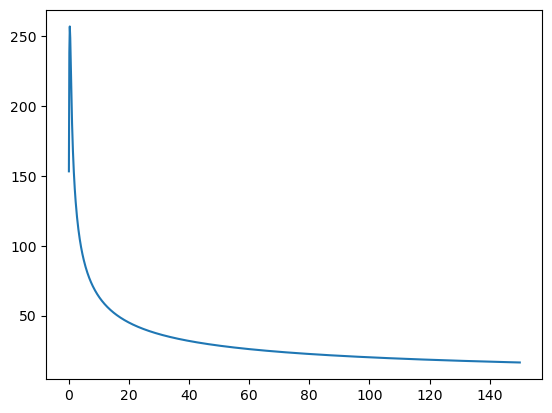

In [8]:
def stellar_bulge_velocity(r, M_b_inner,M_b_outer,
                           scale_radius_inner=0.0035,scale_radius_outer=0.120,
                          G=G.to(units.kpc**3 / units.M_sun / units.s**2).value):
    """
    Compute the circular velocity of a stellar bulge with a Plummer profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distances in kpc.
    M_b_inner : float
        Total mass of the inner bulge in solar masses.
    scale_radius_inner : float, optional. Default: 0.0035 from Sofue paper (2016)
        Inner Bulge scale radius in kpc.
    M_b_outer : float
        Total mass of the outer bulge in solar masses.
    scale_radius_inner : float, optional. Default: 0.120 from Sofue paper (2016)
        Outer Bulge scale radius in kpc.
        

    Returns
    -------
    velocities : float or array_like
        Circular velocities in km/s.
    """ 
    
    def f(z):
        return 1 - np.exp(-z)*(1+z+(z)**2/2)
    
    x = r/scale_radius_inner
    y = r/scale_radius_outer

    term1 = (G*M_b_inner*f(x))/(scale_radius_inner*x)

    term2 = (G*M_b_outer*f(y))/(scale_radius_outer*y)
    
    velocities = np.sqrt(term1 + term2)*units.kpc/units.s
    
    return velocities.to(units.km/units.s).value

#quick plot to check
r = np.linspace(0.1,150,1000)
v_b = stellar_bulge_velocity(r, 5.4e7, 9.4e9)
plt.plot(r,v_b)

## Defining the stellar disk velocity

The following is from Sofue (2020). Can also be found from (Sofue 2016, doi: 10.1093/pasj/xxx000, pg 24):

The galactic disk is represented by an exponential disk (Freeman 1970), where the surface mass density is expressed as

$$\Sigma_d(R) = \Sigma_{dc}(R)exp(\frac{-R}{R_d})$$

Where $\Sigma_{dc}$ is the central value and $R_d$ is the scale radius. The rotation curve for such a thin exponential disk is expressed by (Binney and Tremaine 1987):

$$V_{d(R)}^2 = 4\pi G \Sigma_0 R_dy^2[I_0(y)K_0(y) - I_1(y)K_1(y)]$$

where y = R/2Rd and I and K are the modified Bessel functions.

The total mass of the disk (the nuisance parameter) is given by $M_{dc} = 2\pi \Sigma_{dc}R_d^2 $

(0.0, 100.0)

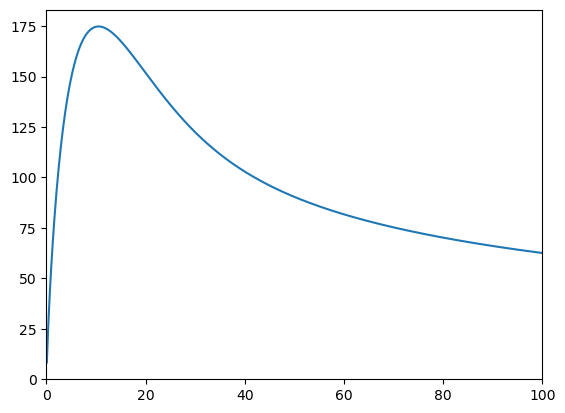

In [9]:
#This works. Free parameter here would be the total disk surface mass density. 
#We can also set R_d to be a free parameter, but I think scale length is well known generally
def stellar_disk_velocity(r,
                          M_dc,
                          R_d=4.9,
                          G=G.to(units.kpc**3/(units.s**2*units.M_sun))
                          ):
    """
    Compute the circular velocity of a stellar disk with an exponential profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distances in kpc.
    M_dc : float
        Total mass of the disk in solar masses.
    R_d : float, optional. Default: 4.9 kpc from Sofue paper (2016)
        Disk scale length in kpc.
    G : float, optional. Default units: 4.30091e-06 kpc^3/Gyr^2/M_sun

    Returns
    -------
    velocities : float or array_like
        Circular velocities in km/s.

    """
    r = r * units.kpc
    M_dc = M_dc * units.M_sun
    R_d = R_d * units.kpc
    sigma_dc = M_dc/(2*np.pi*R_d**2)
    y = r/(2*R_d)
    bessel = sp.special.i0(y)*sp.special.k0(y) - sp.special.i1(y)*sp.special.k1(y)  
    velocities = (4*np.pi*G*sigma_dc*R_d*(y**2)*bessel)**0.5
    return velocities.to(units.km/units.s).value

#quick plot to check
v_d = stellar_disk_velocity(r,0.9e11)
plt.plot(r,v_d)
plt.xlim(0, 100)


## Defining the dark matter density and circular velocity

The dark matter distribution within the Galaxy can be found using a spherical generalized Navarro, Frenk, and White (gNFW) profile (from main paper):

$$
\rho_{\text{gNFW}}(r) = \rho_0 \left( \frac{R_0}{r} \right)^\gamma \left( \frac{r_s + R_0}{r_s + r} \right)^{3-\gamma}
$$

where:

- $\rho_0$: The dark matter density at the Sun's location, $R_0$.
- $R_0$: The radius of the Sun's location from the Galactic center $R_0 = 8.34 \, \text{kpc} $.
- $r_s$: The characteristic radius of the dark matter halo.
- $\gamma$: The inner slope of the density profile.

### Enclosed Mass

The enclosed mass within a sphere of radius R is:

$$
M_{\text{DM}}(<r) = 4\pi \int_0^r \rho_{\text{gNFW}}(r) \, R^2 \, dR
$$

### Angular Velocity

For a circular orbit, the angular velocity due to the dark matter halo is:

$$
v_{\text{DM}}^2(r) = \frac{G M_{\text{DM}}(<r)}{r}
$$

where G is the gravitational constant.

/opt/conda/lib/python3.11/site-packages/galpy/potential/Potential.py:1180: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(R * -self.Rforce(R, 0.0, phi=phi, t=t, use_physical=False))



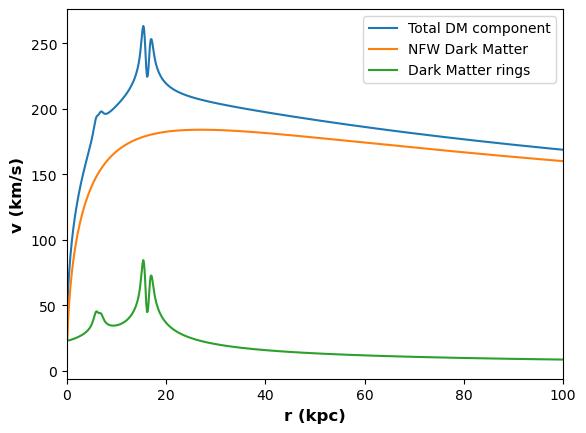

In [10]:
import galpy 
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from scipy.ndimage import gaussian_filter1d

# Convert densities from Gev/cm^3 to Msun/kpc**3
density_conversion = 22632500000/851 * units.M_sun / (units.kpc**3)

def halo_vcirc(r,
               rho_0,
               r_s,
               R_0=r_sun.value):

    # Convert the density into consistent units
    rho_0 =  rho_0 * density_conversion

    # Add units to quantities
    R_0 = R_0 * units.kpc
    r_s = r_s * units.kpc

    # Define the amplitude (total mass)
    halo_amp = rho_0 * 4 * np.pi * R_0**4 * (1 + R_0/r_s)**2 / r_s

    # Create the potential
    halo_potential = galpy.potential.NFWPotential(amp=halo_amp, 
                                  a=r_s, # scale radius 
                                  normalize=False, 
                                  rmax=None, 
                                  vmax=None, 
                                  conc=None, 
                                  mvir=None, 
                                  vo= None, #220 * units.km / units.s, 
                                  ro= None , #8.53 * units.kpc, 
                                  H=70.0, 
                                  Om=0.3, 
                                  overdens=200.0, 
                                  wrtcrit=False)

    # Return the circular velocities
    return halo_potential.vcirc(r)


# Convert densities
rho_inner = 3.5 * density_conversion 
rho_outer = 2.1 * density_conversion

# Define of the rings
centre_inner_ring = 1.5*4.2 #* units.kpc
centre_outer_ring = 1.3*12.4 #* units.kpc

# Gaussian widths of the rings
sigma_inner = 1.2 * units.kpc
sigma_outer = 3.2 * units.kpc

# Define amplitudes of the rings
amp_inner = rho_inner * 4/3 * np.pi * sigma_inner**3
amp_outer = rho_outer * 4/3 * np.pi * sigma_outer**3

# Use a ring potential approximation
ring_1_potential = potential.RingPotential(amp=amp_inner, # inner_ring_mass,
                                              a= sigma_inner, 
                                              normalize=False,
                                              ro=8.53 * units.kpc,
                                              vo=220 * units.km / units.s)

# Use a ring potential approximation
ring_2_potential = potential.RingPotential(amp= amp_outer, # outer_ring_mass, 
                                                 a=sigma_outer, 
                                                 normalize=False, 
                                                 ro=8.53 * units.kpc, 
                                                 vo=220 * units.km / units.s)



def ring_vcirc_scalar(r): 

    # Define circular velocities with offsets to represent the centres of the rings
    r_ring_1 = centre_inner_ring - r
    ring_1_vcirc = np.nan_to_num(ring_1_potential.vcirc(r_ring_1))
    r_ring_2 = centre_outer_ring - r
    ring_2_vcirc = np.nan_to_num(ring_2_potential.vcirc(r_ring_2))

    # Return the sum of their circular velocities
    return ring_2_vcirc + ring_1_vcirc

def ring_vcirc(r):

    ring_vcirc_vectorised = np.vectorize(ring_vcirc_scalar)

    return ring_vcirc_vectorised(r)

def analytic_dm_velocity(r,rho_0,r_s,R_0=r_sun.value,
            G=G.to(units.kpc**3 /units.M_sun/units.s**2).value):
    """"
    Compute the density profile of a dark matter halo with a GNFW profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distance values in kpc.
    rho_0 : float
        Central density value in GeV/cm³.
    r_s : float
        Scale radius value in kpc.
    R_0 : float, optional. Default: 8.34 kpc
        Solar galactocentric distance value in kpc.

    Returns
    -------
    density : float or array_like
        Density profile value in kg/kpc³.
    """
    
    rho_0 = rho_0 * (0.0075/0.3) *units.M_sun / units.pc**3
    rho_0 = rho_0.to(units.M_sun/units.kpc**3).value
    mass_integral = 4*np.pi*rho_0*R_0*(r_s+R_0)**2*(np.log(r_s+r) - np.log(r_s) + (r_s/(r_s+r)) - 1)
    
    velocities = np.sqrt(G*mass_integral/r)*units.kpc/units.s

    return velocities.to(units.km/units.s).value

    
def dm_velocity(r,
                rho_0,
                r_s,
                R_0=r_sun.value):
    
    v_dm = analytic_dm_velocity(r, rho_0, r_s) + gaussian_filter1d(ring_vcirc(r), sigma=2.5)

    return v_dm



#quick plot to check
rho_0 = 0.4
r_s = 12.5

v_rings = gaussian_filter1d(ring_vcirc(r), sigma=2.5)
v_halo = analytic_dm_velocity(r, rho_0, r_s)
v_dm = dm_velocity(r, rho_0, r_s)

plt.plot(r, v_dm, label="Total DM component")
plt.plot(r, v_halo, label="NFW Dark Matter")
plt.plot(r, v_rings, label="Dark Matter rings")
plt.xlabel('r (kpc)',fontweight="bold",fontsize="large")
plt.xlim(0, 100)
plt.ylabel('v (km/s)',fontweight="bold",fontsize="large")
plt.legend()


## GLOBAL MODEL OF THE GALAXY

Fit a global model of the Galaxy that consists of three components: stellar disk, stellar bulge and dark matter halo,

$$
v_c^2(\Theta, M_{dc}, M_b) = v_{\text{disk}}^2(M_{dc}) + v_{\text{bulge}}^2(M_b) + v_{\text{DM}}^2(\Theta),
$$

where the first three baryonic components are presented in section 2.1.2 and the dark matter component (see section 2.2) depends on parameters $ \Theta = (\rho_0, r_s, \gamma)$. Note that each term in eq. (3.1) is implicitly a function of galactocentric radius $ r $ 

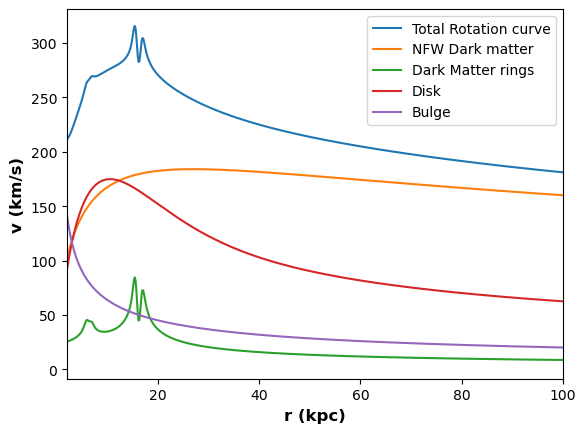

In [11]:
def omega_c(r, r_s, rho_0, M_b_inner,M_b_outer, M_dc):  
    """
    Compute the angular velocity of the Milky Way rotation curve.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distance values in kpc.
    r_s : float
        Scale radius of the dark matter halo, value in kpc.
    gamma : float
        Inner slope of the dark matter halo.
    rho_0 : float
        Central density of the dark matter halo, value in GeV/cm³.
    M_b : float
        Total mass of the bulge in solar masses.
    M_dc : float
        Total mass of the disk in solar masses.

    Returns
    -------
    velocities : float or array_like
        Circular velocity values in km/s.
    """
    r = np.array(r)

    v_bulge = stellar_bulge_velocity(r,M_b_inner,M_b_outer)
    v_disk = stellar_disk_velocity(r,M_dc)
    v_DM = dm_velocity(r,rho_0,r_s)
    
    v_c = np.sqrt(v_bulge**2+v_disk**2+v_DM**2)
    return v_c


v_c = omega_c(r, 12.5,0.4,5.4e7,9.4e9,0.9e11)

plt.plot(r,v_c,label="Total Rotation curve")
plt.plot(r,v_halo,label="NFW Dark matter")
plt.plot(r,v_rings,label="Dark Matter rings")
plt.plot(r,v_d,label="Disk")
plt.plot(r,v_b,label="Bulge")
plt.xlabel("r (kpc)", fontweight = "bold", fontsize = "large")
plt.ylabel("v (km/s)", fontweight = "bold", fontsize = "large")
#plt.ylim(0, max(v_c))
plt.xlim(2, 100)
plt.legend()

The global model of the galaxy is required as an angular velocity in the likelihood function, thus we define a seperate function: 

# Defining the likelihood function

Define the logarithm of the likelihood probability given the model parameters, where the likelihood function takes the form:

$$
P(d | \Theta, M_b, M_{dc}) = \prod_{i=1}^m 
\left\{ 
\frac{1}{\sqrt{2\pi \sigma_{\bar{\omega},i}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( \omega(r_i, \Theta, M_b, M_{dc}) - \bar{\omega}_i \right)^2}{\sigma_{\bar{\omega},i}^2} 
\right] 
\right\}
$$

$$
\times \frac{1}{\sqrt{2\pi} \sigma_{M_{dc}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_{dc} - M_{dc}^{\text{obs}} \right)^2}{\sigma_{M_{dc}}^2} 
\right] 
$$

$$
\times \frac{1}{\sqrt{2\pi \sigma_{M_b}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_b - M_b^{\text{obs}} \right)^2}{\sigma_{M_b}^2} 
\right]
$$

where:

* $\Theta = (r_s, \gamma, \rho_0)$ are the parameters
* $\bar{\omega}_i$ is the measured angular velocity
* $\sigma_{\omega,i}$ is the corresponding uncertainty,
* $i$ runs over the radial RC bins.

The logarithm of the likelihood function is given by:

$$
P(d | \Theta, M_b, M_{dc}) = \prod_{i=1}^m 
\left\{ 
\frac{1}{\sqrt{2\pi \sigma_{\bar{\omega},i}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( \omega(r_i, \Theta, M_b, M_{dc}) - \bar{\omega}_i \right)^2}{\sigma_{\bar{\omega},i}^2} 
\right] 
\right\}
$$

$$
\times \frac{1}{\sqrt{2\pi} \sigma_{M_{dc}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_{dc} - M_{dc}^{\text{obs}} \right)^2}{\sigma_{M_{dc}}^2} 
\right] 
$$

$$
\times \frac{1}{\sqrt{2\pi \sigma_{M_b}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_b - M_b^{\text{obs}} \right)^2}{\sigma_{M_b}^2} 
\right]
$$

In [12]:
def log_likelihood(theta, data):

    r_s, rho_0, M_b_inner, M_b_outer, M_dc = theta

    r, omega_c_obs, omega_c_obs_error, m_b_inner_obs, m_b_inner_error, m_b_outer_obs, m_b_outer_error, m_dc_obs, m_dc_error = data
    
    omega_c_model = omega_c(r, r_s, rho_0, M_b_inner, M_b_outer, M_dc)

    
    term1 = -0.5*np.sum((omega_c_model - omega_c_obs)**2/omega_c_obs_error**2 - 0.5*len(r)*np.log(2 * np.pi * omega_c_obs_error**2))

    term2 = -0.5* ((M_b_inner - m_b_inner_obs) **2/ m_b_inner_error ** 2) - 0.5*np.log(2 * np.pi * m_b_inner_error**2)

    term3 = -0.5 * ((M_b_outer - m_b_outer_obs)**2/m_b_outer_error** 2 ) - 0.5*np.log(2 * np.pi * m_b_outer_error**2)

    term4 = -0.5 * ((M_dc - m_dc_obs)**2/ m_dc_error ** 2) - 0.5*np.log(2 * np.pi* m_dc_error**2)

    # Total log likelihood
    likelihood_value = term1 + term2 + term3 + term4
    
    return likelihood_value

# Defining the priors

For a given morphology, our model has five free parameters: the scale radius of the dark matter halo $r_s$, the inner dark matter density slope $\gamma$, the local dark matter density $\rho_0$, the microlensing optical depth $\langle \tau \rangle$, and the stellar surface density $\Sigma_\ast$. We explore the model parameter space using uniform \textbf{priors} in the following variables and ranges:

$$
0 < r_s / \mathrm{[kpc]} < 40, \\
0 < \gamma < 3, \\
0 < \rho_0 / [\mathrm{GeV \, cm^{-3}}] < 1,
$$
$$
19 \times 10^6 < \Sigma_\ast [\mathrm{M_\odot \, kpc^{-2}}] < 57 \times 10^6,
$$
$$
0.1 \times 10^{-6} < \langle \tau \rangle < 4.5 \times 10^{-6}.
$$


In [13]:
def log_prior(theta):
    r_s, rho_0, M_b_inner,M_b_outer, M_dc = theta
    logp =  sp.stats.uniform.logpdf(r_s, loc=0, scale=40)  
    logp += sp.stats.uniform.logpdf(rho_0, loc=0, scale=1)  

    # Nuisance parameters priors (M_b, M_dc), scale is three times the standard deviation of measured values
    #these values taken from Sofue paper (2016)
    logp += sp.stats.uniform.logpdf(M_b_inner, loc=0.1e8, scale=0.6e8)
    logp += sp.stats.uniform.logpdf(M_b_outer, loc=0.86e10, scale=0.12e10)
    logp += sp.stats.uniform.logpdf(M_dc, loc=0.6e11, scale=1.2e11)  
    
    # Check if all priors are within bounds, otherwise return -inf
    if np.isnan(logp) or np.isinf(logp):
        return -np.inf

    return logp

# Prior predictive to check validity of model 

In [14]:
# Prior distributions for each parameter. I tested this for the narrowest
#prior widths, where the width is just the (symmeterized) errors on either side
r_s_prior = sp.stats.uniform(loc=0, scale=40)  # r_s ~ Uniform(0, 40)
rho_0_prior = sp.stats.uniform(loc=0, scale=1)  # rho_0 ~ Uniform(0, 1)
M_b_inner_prior = sp.stats.uniform(loc=0.3e8, scale=0.2e8)  # M_b_inner ~ Uniform(0.1e8, 0.7e8)
M_b_outer_prior = sp.stats.uniform(loc=0.9e10, scale=0.04e10)  # M_b_outer ~ Uniform(0.86e10, 0.98e10)
M_dc_prior = sp.stats.uniform(loc=0.8e11, scale=0.2e11)  # M_dc ~ Uniform(0.6e11, 1.8e11)

def sample_prior(n_samples):
    r_s_samples = r_s_prior.rvs(n_samples)
    rho_0_samples = rho_0_prior.rvs(n_samples)
    M_b_inner_samples = M_b_inner_prior.rvs(n_samples) + np.random.normal(0,0.1e8, n_samples)
    M_b_outer_samples = M_b_outer_prior.rvs(n_samples) + np.random.normal(0,0.02e10, n_samples)
    M_dc_samples = M_dc_prior.rvs(n_samples) + np.random.normal(0,0.1e11, n_samples)
    
    return np.vstack((r_s_samples, rho_0_samples, M_b_inner_samples, M_b_outer_samples, M_dc_samples)).T  

In [15]:
np.random.seed(15)  # For reproducibility
n_samples = 3 # Number of samples

# Observational data
r = huang_data["r"]  # Radial distance (example range)
sigma_omega_c_obs = huang_data["v_err"]  # Observation error


In [16]:
# Evaluate the model for the prior samples for the radii in the dataset
prior_model_predictive = np.array([
    omega_c(r, *params) for params in sample_prior(n_samples)
])

# Add Gaussian noise to get the prior predictive distribution
#Here, I added the gaussian so that it is scaled w.r.t the observation error
#So for larger radii, the observation error also tends to increase
prior_predictive = np.empty_like(prior_model_predictive)
for i in range(len(r)):  # Loop over radial distances
    prior_predictive[:, i] = (
        prior_model_predictive[:, i]
        + sigma_omega_c_obs[i] * np.random.normal(size=n_samples)
    )
    

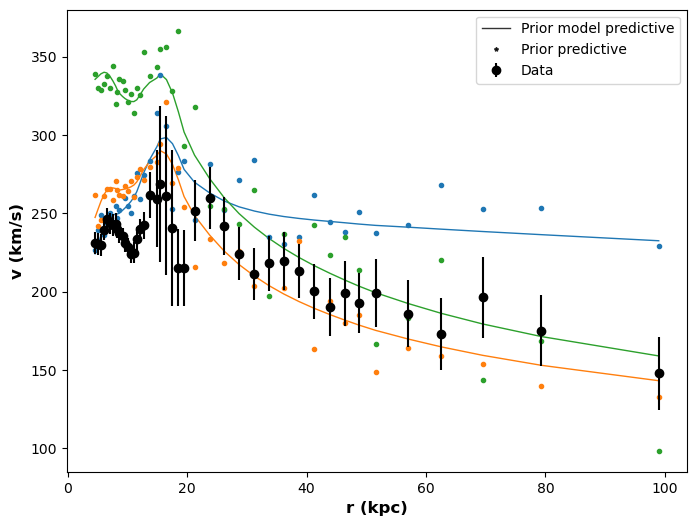

In [32]:
# Plotting
def plot_prior_predictive_with_noise(r, prior_model_predictive, prior_predictive):
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot prior model predictive curves
    for i in range(len(prior_model_predictive)):
        ax.plot(r, prior_model_predictive[i], c=f"C{i}", lw=1, label=None)
    
    # Plot prior predictive curves with noise
    for i in range(len(prior_predictive)):
        ax.plot(r, prior_predictive[i], c=f"C{i}", ls="none", marker="o", ms=3, label=None)
    pmp_style = dict(lw=1, alpha=0.8)
    pp_style = dict(ls="none", marker="*", ms=3, alpha=0.8)
    ax.plot([], [], label="Prior model predictive", c="black",**pmp_style)
    ax.plot([], [], label="Prior predictive", c="black",**pp_style)
    ax.errorbar(huang_data["r"],huang_data["v"],yerr=huang_data["v_err"],fmt="ko",label="Data")
    ax.set_xlabel("r (kpc)",fontweight="bold",fontsize="large")
    ax.set_ylabel("v (km/s)",fontweight="bold",fontsize="large")
    ax.legend()
    plt.savefig('./Figures with rings/prior predictive.png')
    plt.show()

# Call the plotting function
plot_prior_predictive_with_noise(r, prior_model_predictive, prior_predictive)


# Defining the posterior

To perform MCMC sampling of the posterior using `emcee`, we need a function which computes the logarithm of the prior

In [18]:
def log_posterior(theta,data):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + log_likelihood(theta,data)


# MAP estimate

Get initial positions for the mcmc sampling using the MAP 

In [19]:
# Define the negative of the log posterior
def neg_log_posterior(theta, data): 
    return - log_posterior(theta, data)

# Make an initial guess of the parameters
initial_guess = np.array([12.5, 0.4, 0.4e8, 0.92e10, 0.9e11])
variation = 0.1
initial_guess = initial_guess + initial_guess * np.random.uniform(-variation, variation, size=initial_guess.shape)

# Access the data (in this case the filtereed Huang data)
data = (huang_data["r"], 
        huang_data["v"], 
        huang_data["v_err"],
        0.4e8,
        0.1e8,
        0.92e10,
        0.02e10, 
        0.9e11, 
        0.1e11)

# Use scipy.optimize.minimize to minimize the negative log-posterior
MAP_result = sp.optimize.minimize(
    neg_log_posterior,
    initial_guess,
    args=(data,),
    method="Nelder-Mead"
)

print(f"Optimisation successful: {MAP_result.success}")


Optimisation successful: True


MAP results: 
 r_s_MAP = 17.479376875405713 
 rho_0_MAP = 0.25067407213701864
 M_b_inner_MAP = 40114990.80776607
 M_b_outer_MAP = 9245995978.780586
 M_dc_MAP = 75037436700.14212


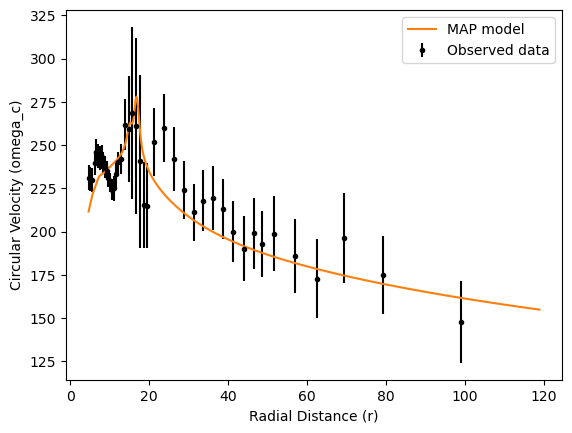

In [20]:
r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP = MAP_result.x
print(f"MAP results: \n r_s_MAP = {r_s_MAP} \n rho_0_MAP = {rho_0_MAP}\n M_b_inner_MAP = {M_b_inner_MAP}\n M_b_outer_MAP = {M_b_outer_MAP}\n M_dc_MAP = {M_dc_MAP}")

# Plotting the best-fit model
r_fine = np.linspace(min(data[0]), max(data[0])+20, 500)  # Fine grid for smooth plotting
fig, ax = plt.subplots()
ax.errorbar(data[0], data[1], yerr=data[2], fmt='.k', label='Observed data')
ax.plot(r_fine, omega_c( r_fine,r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP), label='MAP model', color='C1')
ax.set_xlabel('Radial Distance (r)')
ax.set_ylabel('Circular Velocity (omega_c)')
ax.legend()

# MCMC sampling

In [ ]:
#nwalkers = 100

#nsteps = 25000

#ndim = len(initial_guess)

# Initialize walkers around the MAP estimate
# We add a small random perturbation around the MAP estimate for each walker

#initial_set = np.array([r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP])
#initial_positions = initial_set + 1e-4 * np.random.randn(nwalkers, ndim)

#with Pool(processes = 6) as pool:
#    sampler = emc eee.EnsembleSampler(
#        nwalkers, ndim, log_posterior, args=(data,), pool=pool
#    )

#    state = sampler.run_mcmc(initial_positions, nsteps, progress=True)


In [ ]:
# Extract the chain and log probabilities
#samples = sampler.get_chain()  # Shape: (n_steps, n_walkers, n_parameters)
#log_probs = sampler.get_log_prob()  # Shape: (n_steps, n_walkers)
#acceptance_fractions = sampler.acceptance_fraction  # Shape: (n_walkers,)

# Save the entire chain and log probabilities to .npy files
#np.save("ring_sampler_chain.npy", samples)
#np.save("ring_sampler_log_prob.npy", log_probs)
#np.save("ring_sampler_acceptance_fractions.npy", acceptance_fractions)

In [21]:
chain_per_walker = np.load("./20000 steps /MCMC rings/ring_sampler_chain.npy")

print("Shape of chain:", chain_per_walker.shape)

n_steps, n_walkers, n_params = chain_per_walker.shape


Shape of chain: (25000, 100, 5)


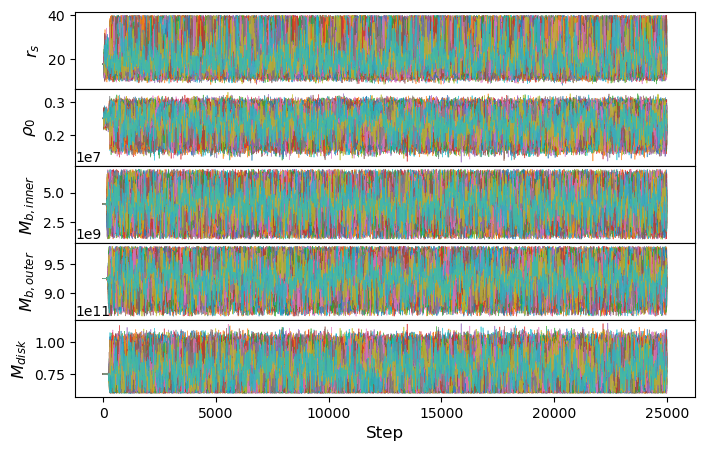

In [22]:
param_names = [r"$r_s$",r"$\rho_0$",r"$M_{b,inner}$",
               r"$M_{b,outer}$",r"$M_{disk}$"]

fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers):
        ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name,fontsize="large")

ax[-1].set_xlabel("Step",fontsize="large");

Integrated auto-correlation time
$r_s$: 76.1
$\rho_0$: 74.5
$M_{b,inner}$: 59.9
$M_{b,outer}$: 61.1
$M_{disk}$: 73.8
(648, 100, 5)


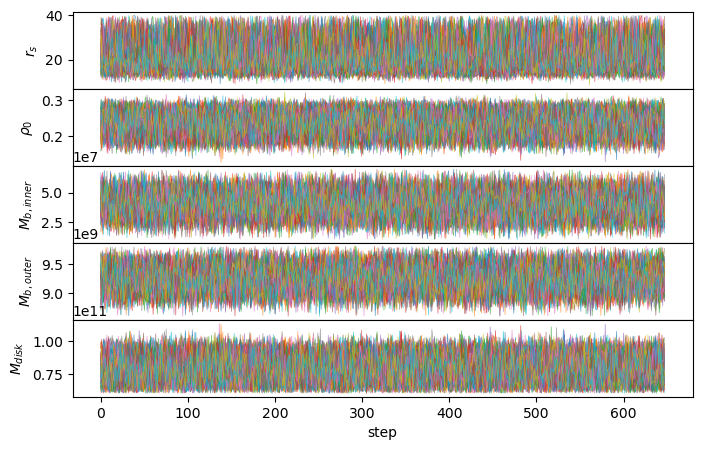

In [23]:
#get autocorrelation times
#in this function, you need to put in the chain as steps,walkers,parameters
tau = emcee.autocorr.integrated_time(chain_per_walker)

print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
    print(f"{name}: {iat:.1f}")

burn_in = int(5*max(tau))
thin = int(max(tau)/2)

thinned_chain = chain_per_walker[burn_in::thin,:, :]
print(thinned_chain.shape)
n_steps_thin, n_walkers_thin, n_params_thin = thinned_chain.shape

# Replotting the trace with thinned out chains
fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers_thin):
        ax[i].plot(thinned_chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step")

plt.savefig('./Figures with rings/trace plot.png')

From the integrated autocorrelation times and assuming that for $n \lesssim 50\tau$, the estimate for $\tau$ will be unreliable, we can see that we would need at least $\approx 4350$ samples. As our chains have $25000$ samples, we can be confident that these autocorrelation times are reliable. 

In [24]:
mean_values = []
std_values = []
for i, param in enumerate(param_names):
    mean = np.mean(thinned_chain[:,:,i])
    std = np.std(thinned_chain[:,:,i])
    mean_values.append(mean)
    std_values.append(std)
    print(f"{param} = {mean:.4g} ± {std:.2g}")

def generate_gaussian(x, mean, amplitude, width):
    return amplitude * np.exp(-0.5 * ((x - mean) / width) ** 2)

print(generate_gaussian(r_sun.value,1.5*4.2,3.5,1.2))
print(generate_gaussian(r_sun.value,1.3*12.4,2.1,3.2))

$r_s$ = 20.97 ± 6
$\rho_0$ = 0.2357 ± 0.031
$M_{b,inner}$ = 4.014e+07 ± 9.9e+06
$M_{b,outer}$ = 9.25e+09 ± 2e+08
$M_{disk}$ = 7.969e+10 ± 9.7e+09
0.8251112679455234
0.10931179927443527


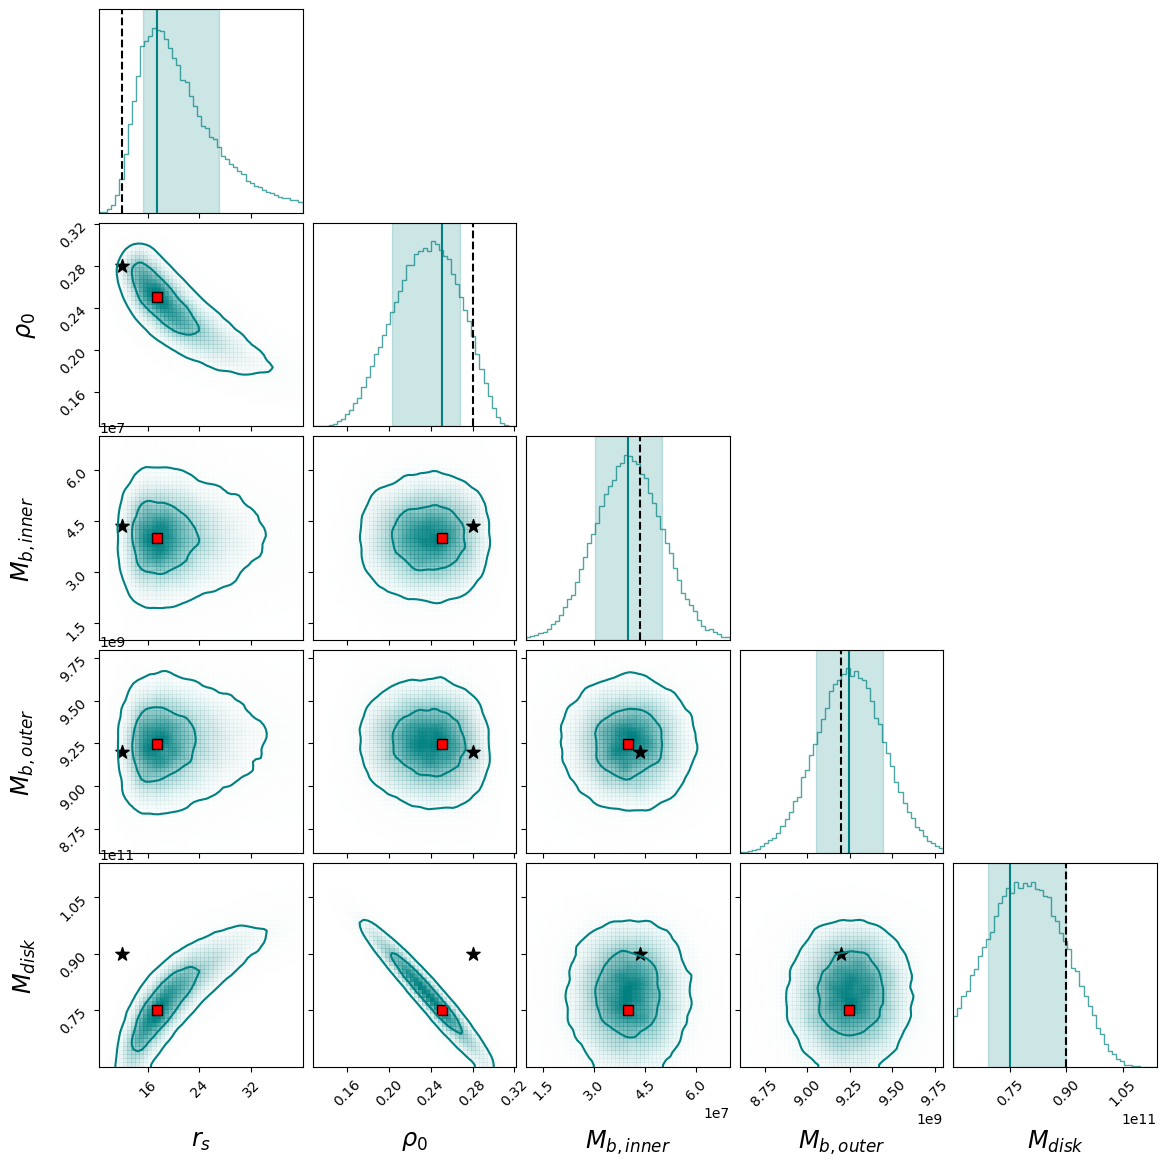

In [25]:
#can use these two lines to create the plot for only specific parameters
#thinned_chain = thinned_chain[:,:,:2]
#param_names = [r"r_s",r"\rho_0"]

literature_values = [12,0.28,0.436e8,0.92e10,0.9e11]

fig = plt.figure(figsize=(12,12))

fig = corner.corner(
    thinned_chain.reshape(-1, n_params_thin),
    bins=50,
    labels=param_names,
    label_kwargs={"fontweight":"bold","fontsize":"xx-large"},
    color="teal",
    plot_datapoints=False,
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    show_titles=False,
    plot_contours=True,
    fill_contours=False,
    smooth=True,
    fig=fig,
    hist_kwargs={"density":True,"alpha":0.7}
);

#manually adding MAP values on the diagonal, and filling in quantiles
chain_flat = thinned_chain.reshape(-1, n_params_thin)  
for i, ax in enumerate(fig.axes):
    if i % (n_params_thin + 1) == 0:  # Diagonal histograms only
        q16, q84 = np.percentile(chain_flat[:, i // (n_params_thin + 1)], [16, 84])
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.axvspan(q16, q84, color="teal", alpha=0.2, label="1σ interval")
        ax.axvline(MAP_result.x[i // (n_params_thin + 1)],color="teal",label="MAP value")
        ax.axvline(literature_values[i // (n_params_thin + 1)],color="black",linestyle="--")

# Adding MAP values as scatter points on 2D histograms (off-diagonal subplots)
for i, ax in enumerate(fig.axes):
    row = i // n_params_thin
    col = i % n_params_thin
    if row > col:  
        ax.scatter(MAP_result.x[col], MAP_result.x[row], 
                   color="red", edgecolor="black", s=50, marker="s",label="MAP value")
        ax.scatter(literature_values[col], literature_values[row], color="black",marker="*",s=100, label="Literature")
        
plt.savefig('./Figures with rings/corner plot.png')

/opt/conda/lib/python3.11/site-packages/galpy/potential/Potential.py:1180: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(R * -self.Rforce(R, 0.0, phi=phi, t=t, use_physical=False))



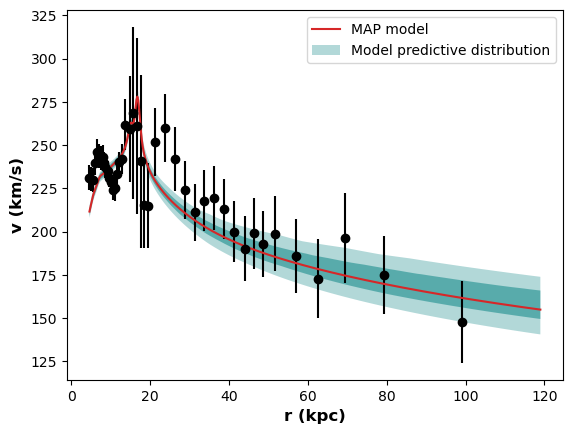

In [26]:
# Choose a small subsample of the chain for plotting purposes
chain_samples = chain_flat[np.random.choice(chain_flat.shape[0], size=200)]

# Evaluate the model at the sample parameters
model_predictive = np.array(
    [omega_c(r_fine,*sample) for sample in chain_samples]
)
model_quantiles = np.quantile(
    model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)



_, ax = plt.subplots()
ax.errorbar(huang_data["r"],huang_data["v"],huang_data["v_err"],fmt="ko")

ax.plot(r_fine,omega_c(r_fine,r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP), 
        c="C3", label="MAP model")
ax.fill_between(r_fine, model_quantiles[0], model_quantiles[-1], alpha=0.3, facecolor="teal",
                label="Model predictive distribution")
ax.fill_between(r_fine, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="teal")
ax.legend()
ax.set_xlabel("r (kpc)",fontweight="bold",fontsize="large")
ax.set_ylabel("v (km/s)",fontweight="bold",fontsize="large")

plt.savefig('./Figures with rings/model fit.png')

# Model comparision

## Bayesian evidence
Using dynesty to sample from the evidence 

In [27]:
def prior_transform_model(u):
    x = np.array([r_s_prior.ppf(u[0]),
                  rho_0_prior.ppf(u[1]),
                  M_b_inner_prior.ppf(u[2]),
                  M_b_outer_prior.ppf(u[3]),
                  M_dc_prior.ppf(u[4])
                 ])
    return x

In [ ]:
#def log_likelihood_wrapper(theta):
#    return log_likelihood(theta,data=data)

#sampler = dynesty.NestedSampler(loglikelihood=log_likelihood_wrapper,
#                               prior_transform=prior_transform_model,
#                               ndim=n_params,
#                               nlive=500)

#sampler.run_nested(print_progress=True)
#sampler.results.summary()

In [ ]:
#with open("./evidence_samples_with_rings.pkl","wb") as f:
#    pickle.dump(sampler.results,f)

In [28]:
with open('./evidence_samples_no_rings.pkl', 'rb') as f:
    no_rings = pickle.load(f)

with open('./evidence_samples_with_rings.pkl', 'rb') as f:
    with_rings = pickle.load(f)
    

In [29]:
log_R = []
for i in range(1000):
    #compute Bayes factor for 1000 samples to give mean + std
    log_z_no_rings = dynesty.utils.jitter_run(no_rings).logz[-1]
    log_z_with_rings = dynesty.utils.jitter_run(with_rings).logz[-1]
    log_R.append(log_z_with_rings - log_z_no_rings)

log_R = np.array(log_R)

R_mean = np.mean(np.exp(log_R))
R_std = np.std(np.exp(log_R))
print(f"Bayes' ratio: {R_mean} ± {R_std}")

Bayes' ratio: 587.4536669898293 ± 91.7302428363543


## Chi-squared with MAP values

In [30]:
def chi_squared(y, sigma_y, mu):
    return np.sum((y - mu)**2/sigma_y**2)

print(r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP)

chi_squared_value = chi_squared(
    huang_data["v"], huang_data["v_err"],
    mu=omega_c(r,r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP))

n_data = len(huang_data["r"])
n_param_lin = 5

PTE_lin = sp.stats.chi2(df=n_data - n_param_lin).sf(chi_squared_value)

print(f"Linear: χ²={chi_squared_value:.1f}, "
      f"ndof={n_data}-{n_param_lin}, PTE={PTE_lin:.3f}")


17.479376875405713 0.25067407213701864 40114990.80776607 9245995978.780586 75037436700.14212
Linear: χ²=53.1, ndof=43-5, PTE=0.053


## DIC criteria

In [31]:
def DIC(theta_star, theta_samples):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star,data)
    log_likelihood_samples = np.array(
        [log_likelihood(theta,data) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

DIC_lin, p_D_lin, p_V_lin = DIC(
    theta_star=(r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP),
    theta_samples=thinned_chain.reshape((-1, thinned_chain.shape[-1])),
)

print(f"{DIC_lin:.1f}, p_D = {p_D_lin:.1f}, p_V = {p_V_lin:.1f}")


-6332.0, p_D = 4.8, p_V = 4.3
